In [143]:
import gym
import numpy as np
import torch
import torch.nn as nn
from collections import namedtuple
from tensorboardX import SummaryWriter
import torch.optim as optim


In [144]:
HIDDEN_SIZE = 128
BATCH_SIZE = 16
PERCENTILE = 70

In [145]:
class Net(nn.Module):
    def __init__(self, obs_size, hidden_size, n_actions):
        super(Net, self).__init__()
        self.net = nn.Sequential(
                nn.Linear(obs_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, n_actions)
        )
    def forward(self, x):
        return self.net(x)

# Rather than
# calculating softmax (which uses exponentiation) and then
# calculating cross-entropy loss (which uses a logarithm of
# probabilities), we can use the PyTorch class nn.CrossEntropyLoss ,
# which combines both softmax and cross-entropy in a single, more
# numerically stable expression.

# The downside
# of this is that we need to remember to apply softmax every time we
# need to get probabilities from our NN's output.

In [146]:
# EpisodeStep : This will be used to represent one single step that
# our agent made in the episode, and it stores the observation
# from the environment and what action the agent completed. We
# will use episode steps from "elite" episodes as training data.
EpisodeStep = namedtuple('EpisodeStep', field_names=['observation','action'])

# Episode : This is a single episode stored as total undiscounted
# reward and a collection of EpisodeStep .
Episode = namedtuple('Episode', field_names=['reward', 'steps'])

In [147]:
def iterate_batches(env, net, batch_size):
    batch = []
    episode_reward = 0.0
    episode_steps = []
    obs=env.reset()[0]
    sm = nn.Softmax()
    i=0
    while True:
        
#         env.render()
        #print(obs, "\n")
        obs_v = torch.FloatTensor(obs) #convert our current observation to a PyTorch tensor
        act_probs_v = sm(net(obs_v))  #get probabilities from our NN's output
        act_probs = act_probs_v.data.numpy()
        
        #Now that we have the probability distribution of actions, we can use
        #it to obtain the actual action for the current step
        action = np.random.choice(len(act_probs), p = act_probs)  
        next_obs, reward, is_done, _, _ = env.step(action)          #the env step output

        episode_reward+=reward          #The reward is added to the current episode's total reward
        episode_steps.append(EpisodeStep(observation = obs, action = action))
        #we save the observation that was used to choose theaction, 
        # but not the observation returned by the environment

        if is_done:
            
#             print(episode_reward)
            
            batch.append(Episode(reward = episode_reward, steps = episode_steps))
            episode_reward = 0.0
            episode_steps=[]
            next_obs = env.reset()[0]
            if len(batch)==batch_size:
                yield batch
                batch = []
             
        obs = next_obs


One very important fact to understand in this function logic is that
the training of our NN and the generation of our episodes are
performed at the same time.

In [148]:
# This function is at the core of the cross-entropy method—from the
# given batch of episodes and percentile value, it calculates a
# boundary reward, which is used to filter "elite" episodes to train on.
def filter_batch(batch, percentile):
    rewards = list(map(lambda s:s.reward, batch))
    reward_bound = np.percentile(rewards, percentile)
    reward_mean = float(np.mean(rewards))
    train_obs = []
    train_act = []
    for reward,steps in batch:
        if reward<reward_bound:
            continue
        # we will populate lists of observations and actions that we will train on
        train_obs.extend(map(lambda step: step.observation, steps))
        train_act.extend(map(lambda step: step.action, steps))
    #we will convert our observations and actions from "elite" episodes into tensors,
    train_obs_v = torch.FloatTensor(train_obs)
    train_act_v = torch.LongTensor(train_act)
    return train_obs_v, train_act_v, reward_bound, reward_mean


In [149]:
# main run
# create the env 
env = gym.make("CartPole-v0")
obs_size = env.observation_space.shape[0]
#print(obs_size)
n_actions = env.action_space.n
# define the model, the objective function to minimize & the optimizer
net = Net(obs_size, HIDDEN_SIZE, n_actions)
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr=0.01)
writer = SummaryWriter

c:\Users\Administrateur\AppData\Local\Programs\Python\Python38\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [152]:
def get_action(obs, net):
    
    obs_v = torch.FloatTensor(obs) #convert our current observation to a PyTorch tensor
    act_probs_v = sm(net(obs_v))  #get probabilities from our NN's output
    act_probs = act_probs_v.data.numpy()

    action = np.random.choice(len(act_probs), p = act_probs)
    return action

In [153]:
def playing_with_agent(net_trained) :   
    total_reward_a = []
    total_steps = 0
    # obs = env.reset()
    sm = nn.Softmax(dim=1)

    for i in range(BATCH_SIZE):
        total_reward = 0.0
        total_steps = 0
        obs = env.reset()[0]
        while True:
            env.render()
            action = get_action(obs, net_trained)
    #         action = env.action_space.sample()
            next_obs, rew, is_done, _,_ = env.step(action)
            total_reward+=rew
            total_steps+=1
            if is_done:
                #print("iter",i," Total Reward = ",total_reward," Total Steps = ", total_steps)            
                total_reward_a.append(total_reward)
                break
            obs=next_obs

    #print('avg rew = ',sum(total_reward_a)/BATCH_SIZE)
    env.close()
    return sum(total_reward_a)/BATCH_SIZE

In [151]:
    #loop through
#epochs=50    
#for i in range(epochs) : 
i=0  
R=[]
for iter_no, batch in enumerate(iterate_batches(env, net, BATCH_SIZE)):
        obs_v, act_v, reward_b, reward_m = filter_batch(batch, PERCENTILE)
        optimizer.zero_grad()
        action_scores_v = net(obs_v)
        loss_v = objective(action_scores_v, act_v)
        loss_v.backward()
        optimizer.step()
        print("%d: loss=%.3f, reward_mean=%.1f, reward_bound=%.1f" % (iter_no, loss_v.item(), reward_m, reward_b))
        # writer.add_scalar("loss", loss_v.item(), iter_no)
        # writer.add_scalar("reward_bound", reward_b, iter_no)
        # writer.add_scalar("reward_mean", reward_m, iter_no)
        avg_reward=playing_with_agent(net)
        R.append(avg_reward)
        i+=1
        if i>30:
            break

        # if reward_m > 1000:
        #     print("Solved!")
        #     break
        #     writer.close()

C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21116\2770266321.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  act_probs_v = sm(net(obs_v))  #get probabilities from our NN's output


0: loss=0.495, reward_mean=138.4, reward_bound=139.5


C:\Users\Administrateur\AppData\Local\Temp\ipykernel_21116\1719624075.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  act_probs_v = sm(net(obs_v))  #get probabilities from our NN's output


1: loss=0.511, reward_mean=158.0, reward_bound=202.0
2: loss=0.505, reward_mean=156.8, reward_bound=184.5
3: loss=0.508, reward_mean=183.8, reward_bound=210.5
4: loss=0.490, reward_mean=153.1, reward_bound=170.0
5: loss=0.478, reward_mean=214.8, reward_bound=289.0
6: loss=0.491, reward_mean=190.8, reward_bound=240.0
7: loss=0.494, reward_mean=216.8, reward_bound=267.5
8: loss=0.497, reward_mean=250.3, reward_bound=353.5
9: loss=0.480, reward_mean=210.8, reward_bound=235.5
10: loss=0.497, reward_mean=167.1, reward_bound=208.0
11: loss=0.488, reward_mean=237.0, reward_bound=315.0
12: loss=0.492, reward_mean=242.2, reward_bound=328.5
13: loss=0.492, reward_mean=259.3, reward_bound=310.5
14: loss=0.490, reward_mean=249.1, reward_bound=315.5
15: loss=0.483, reward_mean=410.1, reward_bound=448.0
16: loss=0.488, reward_mean=332.9, reward_bound=407.5
17: loss=0.468, reward_mean=404.8, reward_bound=465.0
18: loss=0.471, reward_mean=379.3, reward_bound=404.0
19: loss=0.465, reward_mean=358.1, re

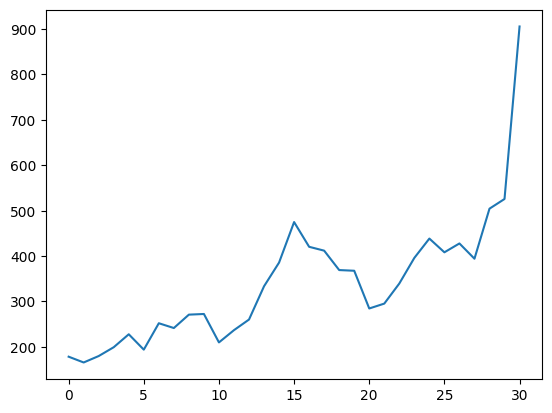

In [154]:
import matplotlib.pyplot as plt
plt.plot([i for i in range(len(R))],R)